# Parameter exploration with `neurolib`

In this example, we will draw a bifurcation diagram of a neural mass model that we load using the brain simulation framework `neurolib`. Please visit the [Github repo](https://github.com/neurolib-dev/neurolib) to learn more about this library or read the [gentle introduction to `neurolib`](https://caglorithm.github.io/notebooks/neurolib-intro/) to learn more about the neuroscience background of neural mass models and whole-brain simulations. 

## What we will do 
We will scan through a 2-dimensional parameter space and record all outputs of the model to a hdf file. We will then load the simulated results from the hdf file and condense the output to a single scalar so we can plot it. Let's get to it!

We'll first start with some unnecessary but useful imports for logging and auto-reloading code. You can skip this block if you don't know what it does.

In [ ]:
# change into the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')

%load_ext autoreload
%autoreload 2

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

We have to install `matplotlib` and `neurolib` for this example, which we can do using the shell command syntax of jupyter using `!pip install matplotlib`.

In [ ]:
# install matplotlib
!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

# install neurolib
!pip install neurolib
# clean up hdf file if it's here
!rm exploration.h5


from neurolib.models.aln import ALNModel

import mopet

We can now load the `ALNModel` model from `neurolib`.

In [3]:
model = ALNModel()
model.params.duration = 1*1000

INFO:root:aln: Model initialized.


Like in other examples, we need to define an `evalFunction` that `mopet` can call. The parameters `params` that are passed to that function are the parameters of the model to run. We load the parameters to the model using a simple dictionary update `old_dict.update(new_dict)`. We then return the output of the model.

In [4]:
def evalFunction(params):
    model.params.update(params)
    model.run()
    return model.outputs

Now we define the parameter ranges to explore (the parameters here are called `mue_ext_mean` and `mui_ext_mean` which represent the background input to two neural populations).

In [5]:
# NOTE: These values are low for testing!
explore_params = {"mue_ext_mean" : np.linspace(0, 3, 3),
                  "mui_ext_mean" : np.linspace(0, 3, 3)}
# For a real run, use these values:
# explore_params = {"mue_ext_mean" : np.linspace(0, 3, 31),
#                   "mui_ext_mean" : np.linspace(0, 3, 31)}

ex = mopet.Exploration(evalFunction, explore_params, default_params=model.params)

Everything is ready and we can now simply run the exploration.

In [6]:
ex.run()

2021-02-15 13:11:15,016	INFO resource_spec.py:212 -- Starting Ray with 3.71 GiB memory available for workers and up to 1.86 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-02-15 13:11:15,408	INFO services.py:1093 -- View the Ray dashboard at localhost:8265
INFO:root:Starting 961 jobs.
100%|██████████| 961/961 [00:09<00:00, 102.31it/s]
INFO:root:Runs took 9.400170087814331 s to submit.
100%|██████████| 961/961 [00:12<00:00, 78.19it/s] 
INFO:root:Runs and storage took 12.292822122573853 s to complete.


After the exploration is done, we can load the results into a pandas Dataframe. By adding the argument `all=True`, we also tell `mopet` to load the simulated output of the exploration into the Dataframe.

In [7]:
ex.load_results(all=True)

INFO:root:exploration.h5 opened for reading.
INFO:root:Gettings runs of exploration ``exploration_2021_02_15_13H_11M_14S``
100%|██████████| 961/961 [00:02<00:00, 329.16it/s]
INFO:root:Creating new results DataFrame
INFO:root:Aggregating scalar results ...
100%|██████████| 961/961 [00:02<00:00, 352.34it/s]
INFO:root:exploration.h5 closed.


The outputs of each run are also stored in the `results` dictionary.

In [8]:
ex.results

{0: {'IA': array([[115.42108613, 115.36337558, 115.3056939 , ...,   0.77789558,
            0.77750663,   0.77711788]]),
  'rates_exc': array([[6.92679660e+01, 5.51285576e+01, 4.56847368e+01, ...,
          3.56640764e-02, 3.56656077e-02, 3.56671382e-02]]),
  'rates_inh': array([[17.53918815, 17.21270968, 16.87237271, ...,  0.03786015,
           0.03786058,  0.037861  ]]),
  't': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
         1.000e+03])},
 1: {'IA': array([[115.42108613, 115.36337558, 115.3056939 , ...,   0.77789558,
            0.77750663,   0.77711788]]),
  'rates_exc': array([[6.92679660e+01, 5.51285576e+01, 4.56847368e+01, ...,
          2.30902533e-02, 2.30910202e-02, 2.30917868e-02]]),
  'rates_inh': array([[17.53918815, 17.21270968, 16.87446883, ...,  0.10619111,
           0.10619153,  0.10619196]]),
  't': array([1.000e-01, 2.000e-01, 3.000e-01, ..., 9.998e+02, 9.999e+02,
         1.000e+03])},
 10: {'IA': array([[115.42108613, 115.36337558, 115.

## Reducing the results

As you can see, the results above are time series. For each simulation, we've got multiple arrays. We would like to visualize the results somehow. However, it can be quite challenging to plot many time series in a single figure and still understand what's happening. Therefore, to reduce the dimensionality of the data to a single scalar number per simulation, we will loop through the entire results Dataframe, grab the time series called `rates_exc` and simply compute its maximum after a transient time of `t>500` time steps. We then store this number in the Dataframe and simply call the new column `result`.

In [9]:
ex.df["result"] = None
for r in ex.df.index:
    t = ex.results[r]['t']    
    rates_exc = ex.results[r]['rates_exc']
    ex.df.loc[r, "result"] = np.max(rates_exc[:, t>500])

We can now inspect the updated dataframe using the attribute `.df`. 

In [10]:
ex.df

,mue_ext_mean,mui_ext_mean,IA,rates_exc,rates_inh,t,result
0,0,0,"[[115.42108612781462, 115.36337558475071, 115....","[[69.26796604154283, 55.12855764228099, 45.684...","[[17.53918815194797, 17.21270968489486, 16.872...","[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...",0.0356671
1,0,0.1,"[[115.42108612781462, 115.36337558475071, 115....","[[69.26796604154283, 55.12855764228099, 45.684...","[[17.53918815194797, 17.21270968489486, 16.874...","[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...",0.0230918
10,0,1,"[[115.42108612781462, 115.36337558475071, 115....","[[69.26796604154283, 55.12855764228099, 45.684...","[[17.53918815194797, 17.21270968489486, 16.893...","[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...",4.49792e-08
100,0.3,0.7,"[[115.42108612781462, 115.36337558475071, 115....","[[69.26796604154283, 55.12855764228099, 45.706...","[[17.53918815194797, 17.21270968489486, 16.887...","[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...",0.00577115
101,0.3,0.8,"[[115.42108612781462, 115.36337558475071, 115....","[[69.26796604154283, 55.12855764228099, 45.706...","[[17.53918815194797, 17.21270968489486, 16.889...","[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...",0.00123912
...,...,...,...,...,...,...,...
96,0.3,0.3,"[[115.42108612781462, 115.36337558475071, 115....","[[69.26796604154283, 55.12855764228099, 45.706...","[[17.53918815194797, 17.21270968489486, 16.878...","[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...",0.767233
960,3,3,"[[115.42108612781462, 115.36337558475071, 115....","[[69.26796604154283, 55.12855764228099, 45.906...","[[17.53918815194797, 17.21270968489486, 16.935...","[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...",63.4027
97,0.3,0.4,"[[115.42108612781462, 115.36337558475071, 115....","[[69.26796604154283, 55.12855764228099, 45.706...","[[17.53918815194797, 17.21270968489486, 16.880...","[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...",0.225702
98,0.3,0.5,"[[115.42108612781462, 115.36337558475071, 115....","[[69.26796604154283, 55.12855764228099, 45.706...","[[17.53918815194797, 17.21270968489486, 16.882...","[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.60...",0.0704494


As you can see, the column `result` only has a single number for each run. Perfect for plotting! In order to plot this long-format Dataframe, we need to pivot it to create a new Dataframe `pivoted` which has the correct x and y coordinates for plotting the `results` value.

In [11]:
pivoted = ex.df.pivot_table(values='result', index = 'mui_ext_mean', columns='mue_ext_mean', aggfunc='first')

Let's have a look at the new Dataframe that we're about to plot.

In [12]:
pivoted

mue_ext_mean,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3.0
mui_ext_mean,,,,,,,,,,,,,,,,,,,,,
0.0,3.566714e-02,5.038073e+00,2.025389e+01,3.674348e+01,5.033596e+01,6.057443e+01,6.792469e+01,7.205380e+01,7.212920e+01,6.390489e+01,...,5.204773e+01,5.536249e+01,5.862604e+01,61.839978,65.006270,68.125977,71.201859,74.234977,77.226649,80.178835
0.1,2.309179e-02,1.893093e-01,6.573055e+00,1.973052e+01,3.464734e+01,4.793192e+01,5.856197e+01,6.619381e+01,6.966394e+01,6.840042e+01,...,4.956086e+01,5.297202e+01,5.632147e+01,59.612008,62.847173,66.029777,69.162763,72.248066,75.288125,78.285311
0.2,1.139727e-02,6.566545e-02,5.777425e-01,6.942009e+00,1.867513e+01,3.216752e+01,4.505146e+01,5.590772e+01,6.364450e+01,6.642131e+01,...,4.733510e+01,5.084602e+01,5.428230e+01,57.648712,60.951266,64.194099,67.380941,70.515759,73.601047,76.639324
0.3,4.980980e-03,2.668306e-02,1.389261e-01,7.672331e-01,6.834751e+00,1.729525e+01,2.995169e+01,4.232013e+01,5.307061e+01,6.054178e+01,...,4.534479e+01,4.895815e+01,5.248024e+01,55.920889,59.288067,62.587445,65.825477,69.005410,72.132165,75.208225
0.4,1.774000e-03,9.545725e-03,4.632592e-02,2.257016e-01,8.299970e-01,6.339486e+00,1.589181e+01,2.803041e+01,3.995661e+01,5.030109e+01,...,4.356350e+01,4.727974e+01,5.088630e+01,54.398174,57.826662,61.179190,64.464000,67.686022,70.850201,73.960529
0.5,5.518867e-04,3.117537e-03,1.578428e-02,7.044940e-02,2.879694e-01,8.278262e-01,5.770501e+00,1.441105e+01,2.621844e+01,3.785076e+01,...,4.196489e+01,4.578350e+01,4.947261e+01,53.052735,56.538380,59.940886,63.268404,66.529015,69.727161,72.868326
0.6,1.410664e-04,8.584281e-04,4.675732e-03,2.175138e-02,8.921891e-02,3.212336e-01,7.906348e-01,5.012672e+00,1.280725e+01,2.432060e+01,...,4.052428e+01,4.444487e+01,4.821441e+01,51.859508,55.398690,58.846881,62.214551,65.509289,68.738692,71.907518
0.7,2.666909e-05,1.844340e-04,1.102892e-03,5.771147e-03,2.571231e-02,1.005409e-01,3.231891e-01,7.281859e-01,4.219999e+00,1.112888e+01,...,3.922140e+01,4.324317e+01,4.708968e+01,50.795865,54.385822,57.876537,61.280031,64.606649,67.864156,71.057823
0.8,4.009508e-06,3.179702e-05,2.147151e-04,1.239125e-03,6.370432e-03,2.781132e-02,1.034079e-01,3.051518e-01,6.506604e-01,3.399014e+00,...,3.803692e+01,4.215889e+01,4.607996e+01,49.844377,53.481517,57.011032,60.447884,63.803446,67.086149,70.302511


Perfect, that's exactly what we need. We have two indices, which are both equal to the paramters that we have explored before. The only entry of the Dataframe is the `results` value that we've put in before. Now, let's plot this Dataframe using `matplotlib.imshow()`.

Text(0, 0.5, 'Input to I')

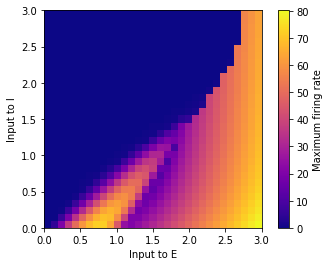

In [13]:
plt.imshow(pivoted, \
           extent = [min(ex.df.mue_ext_mean), max(ex.df.mue_ext_mean),
                     min(ex.df.mui_ext_mean), max(ex.df.mui_ext_mean)], origin='lower')
plt.colorbar(label='Maximum firing rate')
plt.xlabel("Input to E")
plt.ylabel("Input to I")